In [2]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from utils import label_accuracy_score, add_hist
import cv2
import copy

import numpy as np
import pandas as pd
from tqdm import tqdm

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch
import webcolors

import segmentation_models_pytorch as smp
from data_api import CustomDataset

batch_size = 1
device = "cuda" if torch.cuda.is_available() else "cpu"

# TODO
# 모델 지정
model = smp.DeepLabV3Plus(
    encoder_name="efficientnet-b5",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=11,                      # model output channels (number of classes in your dataset)
)

# TODO
# 저장할 json 파일 이름 지정
pseudo_labeling_name = 'model_10_threshold_75'

# TODO
# 체크포인트 경로 지정
model_path = '/opt/ml/segmentation/baseline_code/saved/DeepLabV3Plus_efficientnet-b5_best_model.pt'
dataset_path  = '/opt/ml/segmentation/input/data'
test_path = dataset_path + '/test.json'

# best model 불러오기
checkpoint = torch.load(model_path, map_location=device)
state_dict = checkpoint.state_dict()
# state_dict = checkpoint['net']
model.load_state_dict(state_dict)

model = model.to(device)

test_transform = A.Compose([
    ToTensorV2()
    ])

test_dataset = CustomDataset(annotation='test.json', mode='test', transform=test_transform)


def collate_fn(batch):
    return tuple(zip(*batch))

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          num_workers=4,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [4]:
# json 파일 불러오기

submission = pd.read_csv('/opt/ml/segmentation/baseline_code/submission/sample_submission.csv', index_col=None)
teain_json_dir = os.path.join("/opt/ml/segmentation/input/data/train.json")
test_json_dir = os.path.join("/opt/ml/segmentation/input/data/test.json")

with open(teain_json_dir, "r", encoding="utf8") as outfile:
    json_train_data = json.load(outfile)
    train_data = copy.deepcopy(json_train_data)
with open(test_json_dir, "r", encoding="utf8") as outfile:
    test_data = json.load(outfile)

last_id = train_data['images'][-1]['id']
print(last_id)

2616


In [5]:
model.eval()
hahahoho = np.array([])
file_name_list = []
anno_id_num = 1
img_id_num = 1
threshold = 7.5

print('합치기전', len(train_data['images']), '장')
with torch.no_grad():
    for step, (imgs, image_infos) in enumerate(tqdm(test_loader)):
        
        outs = model(torch.stack(imgs).to(device))
        mean = torch.mean(torch.max(outs, dim=1)[0])
        mean = mean.cpu().numpy()
        hahahoho = np.append(hahahoho, mean)
        if mean < threshold: continue # 픽셀 당 점수 평균이 threshold를 넘기지 못하면 제외
        oms = torch.argmax(outs, dim=1).detach().cpu().numpy()[0]

        # break
        image_id = test_data["images"][step]
        file_name = image_id["file_name"]
        for seg_class in range(1, 11): # 1:genetral_trash 부터 10 clothing까지

            temp_mask = copy.deepcopy(oms)
            temp_mask[temp_mask != seg_class] = 0 # 현재 클래스와 다른 것들은 다 0 처리
            temp_mask[temp_mask == seg_class] = 1 # binary 이미지로 만들어주기 위함
            if len(np.unique(temp_mask)) == 1: continue # 해당 클래스 없으면 pass

            anno = {}
            anno['id'] = 21115 + anno_id_num
            anno['category_id'] = seg_class
            anno['image_id'] = img_id_num + last_id
            seg_annos = []

            temp_mask = temp_mask.astype(np.uint8)
            temp_mask_boundaries, hierarchy  = cv2.findContours(temp_mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE) # 경계만 추출
            
            for temp_mask_boundary in temp_mask_boundaries:
                seg_anno = np.reshape(temp_mask_boundary, (-1)).tolist()
                seg_annos += seg_anno
            if len(seg_annos) in [2, 4]: # segmentation의 길이가 2나 4이면 mmseg 폴더 나눌 때 에러가 일어남
                print(f'len{len(seg_annos)} raises arror')
                continue
            anno['segmentation'] = [seg_annos]

            train_data['annotations'].append(anno)

            anno_id_num += 1
            
        image_id['id'] = img_id_num + last_id
        # print(image_id)
        # print(anno['image_id'], anno['id'])
        train_data['images'].append(image_id)
        img_id_num += 1

print('합친후', len(train_data['images']), '장')

  0%|          | 0/819 [00:00<?, ?it/s]

합치기전 2617 장


 18%|█▊        | 149/819 [00:08<00:38, 17.39it/s]

len2 raises arror


 21%|██        | 171/819 [00:10<00:38, 16.87it/s]

len2 raises arror


 34%|███▎      | 275/819 [00:15<00:27, 19.56it/s]

len2 raises arror


 39%|███▉      | 318/819 [00:17<00:31, 15.94it/s]

len2 raises arror


 47%|████▋     | 381/819 [00:21<00:20, 21.11it/s]

len4 raises arror


 49%|████▉     | 401/819 [00:22<00:24, 17.23it/s]

len2 raises arror


 53%|█████▎    | 435/819 [00:24<00:20, 18.46it/s]

len4 raises arror


 62%|██████▏   | 509/819 [00:28<00:18, 17.10it/s]

len4 raises arror


 75%|███████▌  | 616/819 [00:34<00:13, 15.17it/s]

len4 raises arror


 81%|████████  | 661/819 [00:36<00:08, 18.16it/s]

len4 raises arror
len2 raises arror
len2 raises arror


100%|██████████| 819/819 [00:45<00:00, 18.14it/s]

합친후 2912 장


[  0   0   0   0   0   0   0   2   4   6  13  14  34  70 164 217 193  88]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6.  6.5 7.  7.5 8.  8.5]


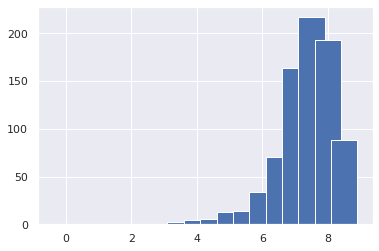

In [6]:
import matplotlib.pyplot as plt
hist, bin_edges = np.histogram(hahahoho, np.arange(start=0, stop=9, step=0.5))
hist = np.insert(hist, 0, 0, axis=0)
print(hist)
print(bin_edges)
plt.bar(bin_edges, height=hist)
plt.show()

In [7]:
with open(f'/opt/ml/segmentation/input/data/{pseudo_labeling_name}.json', 'w') as fp:
    json.dump(train_data, fp)

# pseudo label된 json 파일을 SMP에서 사용할 경우 여기까지만 하고 json 파일을 바로 쓰시면 됩니다.

# (pseudo labeling된 데이터를 MMSegmentation에 사용할 경우) 이미지 폴더 재생성, mask 파일 생성

In [10]:
# 이미지 폴더 재생성, 재분배 (images 폴더 생성)
import shutil

DATAROOT = "/opt/ml/segmentation/input/data"
# trainjson 이름을 pseudo labeling 한 json 파일로 바꿔줍니다.
TRAINJSON = os.path.join(DATAROOT,f"{pseudo_labeling_name}.json")
VALIDJSON = os.path.join(DATAROOT,"val.json")
TESTJSON = os.path.join(DATAROOT,"test.json")

'''
Redistribution image by train/valid/test 

rename img by img_id
'''
def _rename_images(json_dir, image_dir):
	with open(json_dir, "r", encoding="utf8") as outfile:
		json_data = json.load(outfile)
	image_datas = json_data["images"]

	for image_data in image_datas:

		shutil.copyfile(os.path.join(DATAROOT, image_data['file_name']), os.path.join(image_dir,f"{image_data['id']:04}.jpg"))

'''
Wrap func
'''
def make(json,path):
	imagePath = f'/opt/ml/segmentation/input/{pseudo_labeling_name}/images/'+path

	os.makedirs(imagePath, exist_ok=True)
	_rename_images(json,imagePath)


'''
Main
'''
def __main__():

	make(TRAINJSON, 'training')
	make(VALIDJSON, 'validation')

__main__()

/opt/ml/segmentation/input/data/model_10_threshold_75.json
/opt/ml/segmentation/input/data/val.json


In [11]:
transform = A.Compose([
                            A.Resize(512,512),
                            ToTensorV2()
                            ])

train_dataset = CustomDataset(annotation=f"{pseudo_labeling_name}.json", mode='train', transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=False,
                                           num_workers=4,
                                           collate_fn=collate_fn)

loading annotations into memory...
Done (t=2.41s)
creating index...
index created!
loading annotations into memory...
Done (t=1.93s)
creating index...
index created!


In [15]:
if not os.path.exists(f'/opt/ml/segmentation/input/{pseudo_labeling_name}/annotations/training'):
    os.makedirs(f'/opt/ml/segmentation/input/{pseudo_labeling_name}/annotations/training')

for idx, (imgs, masks, image_infos) in enumerate(train_loader):
    image_infos = image_infos[0]
    # 파일 경로를 변경해주세요! .png 형식으로 저장해야 합니다.  
    # 새로 나뉜 이미지를 image_id로 저장해두어서 마찬가지로 annotation도 image_id로 저장합니다. 
    # TODO redist_pseudo 파일에서 설정한 폴더 이름으로 경로 변경
    file_dir = f"/opt/ml/segmentation/input/{pseudo_labeling_name}/annotations/training/{image_infos['id']:04}.png"

    masks = masks[0].numpy()
    
    cv2.imwrite(file_dir, masks)

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/envs/segmentation/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/envs/segmentation/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/tmp/ipykernel_52479/3334506756.py", line 73, in collate_fn
    return tuple(zip(*batch))
TypeError: zip argument #1 must support iteration
